# SAM2 based Pipeline Notebook 

This notebook is meant to present all the details involved in this first pipeline

The goal is to generate a large dataset of labels for brace root images. If we can get this to be very accurate, then we begin the massive task of processing all 2 TB of images.  

Firstly, allow me to use this cell to discuss platform and infrustructure. All of this software is written in using the pytorch framework. My computing platform is my AMD 6800xt with Radeon Open Computing Module (ROCM) for hardware acceleration. This stands in for CUDA which is what most computing platforms use, however, this was my choice because its performant, and more available to me than my department's computer cluster. 

For the most stable installation of ROCM and pytorch for ROCM, I used the official docker image published by AMD and built upon that. 
```dockerfile
FROM rocm/pytorch:latest

# Start with installing python 3.10 
# This image is based off of ubunutu 20.04 which has python 3.8 as default
RUN apt update && \
    apt install -y software-properties-common && \
    add-apt-repository ppa:deadsnakes/ppa && \
    apt update && \
    apt install -y python3.10 python3.10-venv python3.10-dev


# Install pytorch for ROCM 
# venv for SAM2 is created here
RUN python3.10 -m venv /opt/sam2_env && \
    /opt/sam2_env/bin/pip3 install torch torchvision torchaudio \
    --index-url https://download.pytorch.org/whl/rocm6.1 && \
    /opt/sam2_env/bin/pip3 install virtualenv-clone   

# Create python env for root_painter and install
RUN /opt/sam2_env/bin/virtualenv-clone /opt/sam2_env /opt/root_painter_env && \
    git clone https://github.com/KopiousKarp/root_painter.git /opt/root_painter && \
    cd /opt/root_painter && git checkout multiclass && \
    /opt/root_painter_env/bin/pip install \
    --upgrade-strategy eager \
    -r /opt/root_painter/trainer/requirements.txt && \
    /opt/root_painter_env/bin/pip install \ 
    --upgrade-strategy eager \
    -r /opt/root_painter/painter/requirements.txt


# Finish the SAM2 installation
RUN git clone https://github.com/facebookresearch/segment-anything-2.git /opt/sam2 && \
    cd /opt/sam2 && /opt/sam2_env/bin/pip install -e ".[demo]" && \
    cd /opt/sam2/checkpoints && ./download_ckpts.sh

```

An issue that is on the docket to fix is the bloat of this container. `rocm/pytorch:latest` is already bloated at 69 GB but with these extra layers, it ballons to 112GB


## Use Root Painter 
Root painter uses a rudimentary U-Net to segment images, with a small amount of data we can get ballpark masks. They're not clean enough to use for measurement. 



Currently, I dont have a way to launch this from this notebook so it has to be done manually in a shell
```bash
/opt/root_painter_env/bin/python /opt/root_painter/trainer/main.py --syncdir /work/rp_sync
```

In [1]:
import subprocess
segment_command = [
    '/opt/root_painter_env/bin/python',
    '/opt/root_painter/painter/src/main/python/segment_folder.py',
    '--inputdir', '/work/rp_sync/2023',
    '--outputdir', '/work/rp_sync/output',
    '--model', '/work/rp_sync/000034_1723131284.pkl',
    '--syncdir', '/work/rp_sync'
]
subprocess.run(segment_command)

sending instruction


/opt/root_painter/painter/src/main/python/segment_folder.py:27: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class SegmentWatchThread(QtCore.QThread):
/opt/root_painter/painter/src/main/python/segment_folder.py:59: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class SegmentProgressWidget(BaseProgressWidget):
/opt/root_painter/painter/src/main/python/segment_folder.py:70: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class SegmentFolderWidget(QtWidgets.QWidget):


CompletedProcess(args=['/opt/root_painter_env/bin/python', '/opt/root_painter/painter/src/main/python/segment_folder.py', '--inputdir', '/work/rp_sync/2023', '--outputdir', '/work/rp_sync/output', '--model', '/work/rp_sync/000034_1723131284.pkl', '--syncdir', '/work/rp_sync'], returncode=0)

# From Masks to prompts

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

directory_path = '/work/rp_sync/output/'
image_info = {}
for mask_class in ["Marker","Background","Stalk","Root"]:
    mask_directory_path = os.path.join(directory_path, mask_class)
    files = os.listdir(mask_directory_path)

    for file_name in files:
        file_path = os.path.join(mask_directory_path, file_name)
        # print("Processing file: ",file_name)
        image = cv2.imread(file_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        #Apply a threshold or edge detection as needed (optional, depends on the image)
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        #Find contours using OpenCV
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        #Identify the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        #Get moments of the contour
        M = cv2.moments(largest_contour)    
        if(M['m00'] < 20000): #if area is too small, image is nonviable
            # print(file_name ,"Mask nonviable: Area = ",M['m00'])
            if file_name not in image_info:
                    image_info[file_name] = {}  # Initialize if not exists
            image_info[file_name][mask_class] = None
        else:
            # print("Found Mask is viable: Area = ",M['m00'])
            # print("center X : '{}'".format(round(M['m10'] / M['m00'])))
            # print("center Y : '{}'".format(round(M['m01'] / M['m00'])))
            center_x = round(M['m10'] / M['m00'])
            center_y = round(M['m01'] / M['m00'])
            if file_name not in image_info:
                    image_info[file_name] = {}  # Initialize if not exists
            image_info[file_name][mask_class] = (center_x, center_y)
            # There is a possibility that the other points in the moments object can help with accuracy


# plt.show()

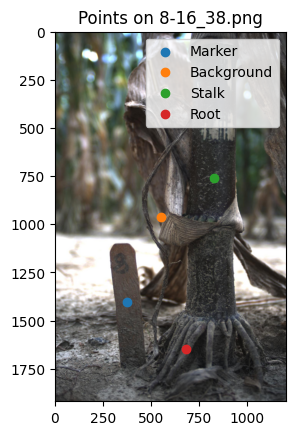

In [3]:
def plot_image_with_points(image_name, image_path, image_info):
    # Load the original image
    image = cv2.imread(image_path)
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the original image
    plt.imshow(image)
    
    # Overlay the points
    if image_name in image_info:
        for mask_class, point in image_info[image_name].items():
            if point is not None:
                # Extract point coordinates
                x, y = point
                # Scatter plot on the image
                # You can customize the marker and color for each class if needed
                plt.scatter(x, y, label=mask_class)
    
    # Customize the plot
    plt.title(f"Points on {image_name}")
    plt.legend()
    
    # Display the plot
    plt.show()

# Example usage
image_name = "8-16_38"
image_path = "/work/rp_sync/2023/" + image_name + ".jpg"
plot_image_with_points(image_name +".png", image_path, image_info)

# Prompting SAM2  
Now we can use SAM2 with the points we just extracted 
A note: we should probably add a step here that saves all the data we just created. Something compact like JSON file for every batch


In [4]:
import torch
from PIL import Image
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [5]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [6]:
image = Image.open('/work/rp_sync/2023/' + image_name + ".jpg")
image = np.array(image.convert("RGB"))

In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [8]:
predictor.set_image(image)

In [22]:
# from pprint import pprint
# for image_entry in image_info:
#     pprint(image_entry)

In [10]:
mask_array = []
for entry_index, image_entry in enumerate(image_info):
    if image_info[image_entry] is not None:    
        image_name = image_entry.split(".")[0] #clipping ".png"
        image = Image.open('/work/rp_sync/2023/' + image_name + ".jpg")
        image = np.array(image.convert("RGB"))
        predictor.set_image(image)
        
        # Ensure mask_array has a sublist for the current entry_index
        if len(mask_array) <= entry_index:
            mask_array.append([])
        mask_set_for_entry = []
        for mask_class in ["Marker","Stalk","Root"]:
            points_list = []
            labels_list = []
            # print("Creating masks for class: ",mask_class)
            for mask_class2, point in image_info[image_name+".png"].items():
                if point is not None:
                    points_list.append(point)
                    if mask_class == mask_class2:
                        labels_list.append(1)
                    else:
                        labels_list.append(0)
            if mask_class == "Root":
                #try using multimask for roots 
                masks, scores, logits = predictor.predict(
                point_coords=np.array(points_list),
                point_labels=np.array(labels_list),
                multimask_output=True
                )
                # for the roots, the best way to capture the entire whorl is 
                # to get the lowest confidence score of the multimask output
                sorted_ind = [np.argsort(scores)[0]]
            else:
                masks, scores, logits = predictor.predict(
                point_coords=np.array(points_list),
                point_labels=np.array(labels_list),
                multimask_output=False
                )
                sorted_ind = np.argsort(scores)[::-1]

            masks = masks[sorted_ind]
            scores = scores[sorted_ind]
            logits = logits[sorted_ind]
            mask_set_for_entry.append(masks[0])
        mask_array[entry_index].append(mask_set_for_entry)
        # show_masks(image, masks, scores, point_coords=np.array(points_list), input_labels=np.array(labels_list))
        

/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:719.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:721.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention was not compiled for current AMD GPU architecture. Attempting to run on architecture gfx1030 (Triggered internally at ../aten/src/ATen/nativ

In [23]:
# print(len(mask_array))
# print(len(mask_array[0]))
# print(len(mask_array[0][0]))

In [12]:
import ipywidgets as widgets
from IPython.display import display

In [13]:
def create_plot(image, mask_array):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colors = [
        (1, 0, 0),  # Red
        (0, 1, 0),  # Green
        (0, 0, 1),  # Blue
        (1, 1, 0),  # Yellow
        (0, 1, 1)   # Cyan
    ]
    visualization = np.zeros_like(image, dtype=np.float32)
    # print(visualization.shape)
    for i, mask in enumerate(mask_array[0]):
        visualization[:, :, i] += mask # * colors[i]
    ax.imshow(image)
    ax.imshow(visualization, alpha=0.25)
    plt.close(fig)  # Close the figure to prevent it from displaying immediately
    return fig
plots = []
for entry_index, image_entry in enumerate(image_info):
    image_name = image_entry.split(".")[0]
    image = Image.open('/work/rp_sync/2023/' + image_name + ".jpg")
    image = np.array(image.convert("RGB"))
    mask = mask_array[entry_index]
    # plots.append(create_plot(image, [np.expand_dims(m, axis=0) for m in mask]))
    plots.append(create_plot(image,mask))
# Create a VBox to hold the plots
plot_widgets = [widgets.Output() for _ in plots]
for plot_widget, plot in zip(plot_widgets, plots):
    with plot_widget:
        display(plot)

# Create a scrollable box
scrollable_box = widgets.VBox(plot_widgets)
scrollable_box.layout = widgets.Layout(overflow='scroll', height='600px', width='1000px')

# Display the scrollable box
display(scrollable_box)

## Graph Analysis of Projections of Image Imbeddings



In [14]:
import base64

def image_to_data_uri(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    return "data:image/jpeg;base64," + encoded_image

In [15]:
labels = [] # use 2 labels. "Complete" or "Incomplete"
train = [] # flattend version of the image
images = [] #image array
image_paths = [] # path variables
err_count = 0
for image_entry in image_info:
    image_path = '/work/rp_sync/2023/' + image_entry.split(".")[0] + ".jpg"
    image_paths.append(image_path)
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    images.append(image)
    if any(value is None for value in image_info[image_entry].values()):
        labels.append("Incomplete")
    else:
        labels.append("Complete")
    if(image.shape is not images[0].shape):
        print("Shapes don't match:", image.shape, images[0].shape)
        err_count +=1 
        #check to rotate
        if(image.shape[0] == images[0].shape[1] and image.shape[1] == images[0].shape[0]):
            print("found image that need to be rotated")
            train.append(image.T.flatten())        
        else:
            print("shapes don't match but we can't just rotate")
            resized_image = cv2.resize(image, (images[0].shape[1], images[0].shape[0]))
            train.append(resized_image.flatten())
    else:
        train.append(image.flatten())
    
labels = np.array(labels)
train = np.array(train)
image_paths = np.array(image_paths)
print(err_count, " miss matched image sizes")


Shapes don't match: (2448, 2048) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (2048, 2448) (2448, 2048)
found image that need to be rotated
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (2048, 2448) (2448, 2048)
found image that need to be rotated
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (2048, 2448) (2448, 2048)
found image that need to be rotated
Shapes don't match: (1920, 1200) (2448, 2048)
shapes don't match but we can't just rotate
Shapes don't match: (2048, 2448) (